In [1]:
from cooltools import snipping
import cooler
import pandas as pd
import numpy as np
import bioframe
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import multiprocess


In [2]:
plt.rcParams.update({'font.size': 16})
chromsizes=bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)
binsize=5000
flank = 300000
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]
binsDf=pd.read_csv('../data/genomeInfo/mm10bin5kb.bed',sep='\t',header=None,names=['chrom','start','end']) #mm10bin5kb.bed file make using cooler makebins
signalFiles=glob.glob('../data/binnedBedgraphs/*')
signalDf=binsDf.copy()
for signalFile in signalFiles:
    signalDf=signalDf.merge(pd.read_csv(signalFile,sep="\t", header=None,names=['chrom','start','end',os.path.basename(signalFile).split('.')[0]]),how='left',on=['chrom','start','end'])
    signalDf.drop_duplicates(subset=['chrom','start','end'],inplace=True)

In [3]:
def getPeakWindowsDf(peakFile,binsize=5000,flank=300000,supports=supports,binsDf=binsDf):
    peakDf=pd.read_csv(peakFile,header=None,sep="\t",names=['chrom','start','end','name','score','strand','signalValue','pvalue','qvalue','peak'])
    windows = snipping.make_bin_aligned_windows(
        binsize,
        peakDf['chrom'],
        (peakDf['start'] + peakDf['end'])//2,
        flank_bp=flank)
    windows=windows.merge(pd.DataFrame(supports,columns=['chrom','zero','chromsize']),how='left',on='chrom')
    windows=windows[(windows.end<windows.chromsize) & (windows.start>0)].drop_duplicates()
    windows=windows.loc[(windows.chrom!='chrX')&(windows.chrom!='chrY')&(windows.chrom!='chrM'),:].reset_index(drop=True)
    startInds=binsDf.reset_index().merge(windows[['chrom','start']],how='right',on=['chrom','start'])['index']
    endInds=binsDf.reset_index().merge(windows[['chrom','end']],how='right',on=['chrom','end'])['index']
    windows['binID']=(endInds+startInds)//2
    return windows
def getPeakSnipWindows(peakFile,binsize=5000,flank=300000,supports=supports,binsDf=binsDf):
    if type(peakFile) is str:
        peakDf=pd.read_csv(peakFile,header=None,sep="\t",names=['chrom','start','end','name','score','strand','signalValue','pvalue','qvalue','peak'])
    elif type(peakFile) is pd.core.frame.DataFrame:
        peakDf=peakFile
    windows = snipping.make_bin_aligned_windows(
        binsize,
        peakDf['chrom'],
        (peakDf['start'] + peakDf['end'])//2,
        flank_bp=flank)
    windows=snipping.assign_regions(windows,supports=supports).drop_duplicates().reset_index(drop=True)
    windows=windows.loc[(windows.chrom!='chrX')&(windows.chrom!='chrY')&(windows.chrom!='chrM'),:].reset_index(drop=True)
    windows['binID']=binsDf.reset_index().merge(windows[['chrom','start']],how='right',on=['chrom','start'])['index']+flank//binsize
    return windows
def splitQuantile(toSplit,splitOn,quantiles=4):
    quantileLims=np.linspace(0,len(toSplit),quantiles+1).astype(int)
    sortedArray=splitOn[toSplit].sort_values().index.to_numpy()
    quantiles=[sortedArray[quantileLims[ind]:quantileLims[ind+1]] for ind in range(quantiles)]
    return quantiles
def diagAverageMat(inputMat):
    imSize=inputMat.shape[0]
    diagAverages=np.zeros(imSize*2-1)
    diagAverageMat=np.zeros((imSize,imSize))
    for diagInd in range(2*imSize-1):
        meanDiagVec=np.nanmean(np.diag(inputMat,diagInd-imSize+1))*np.ones(np.min([diagInd, 2*imSize-2-diagInd])+1)
        diagAverageMat=diagAverageMat+np.diag(meanDiagVec, diagInd-imSize+1)
    return diagAverageMat

def getPairedSnipWindows(snipWindows1,snipWindows2=None,maxDist=1000000,minDist=400000,ordered=True):
    if snipWindows2 is None:
        snipWindows2=snipWindows1
    df=snipWindows1.merge(snipWindows2,on='region',suffixes=[1,2])
    if ordered:
        return df[(np.abs(df.start1-df.start2)<=maxDist)&(np.abs(df.start1-df.start2)>=minDist)&(df.start1<df.start2)]
    else:
        return df[(np.abs(df.start1-df.start2)<=maxDist)&(np.abs(df.start1-df.start2)>=minDist)]

def plotSnipPileup(snipWindows,coolerHandle,ax,vmin=0.95,vmax=1.05,binsize=5000,flank=300000,titleString="",nthreads=8):
    snipper = snipping.CoolerSnipper(coolerHandle)
    with multiprocess.Pool(nthreads) as pool:
        stack = snipping.pileup(
            snipWindows,
            snipper.select,
            snipper.snip,
            map=pool.map)
    avgMat=np.nanmean(stack, axis=2)
    oeMat=avgMat/diagAverageMat(avgMat)
    extent=[-flank/1000,flank/1000,flank/1000,-flank/1000]
    plt.colorbar(mappable=ax.imshow(oeMat,extent=extent, cmap='coolwarm',vmin=vmin, vmax=vmax),
                         ax=ax, shrink=0.6, label='fold enrichment')
    ax.set_aspect('equal')
    ax.set_xlabel('distance to peak (kb)')
    ax.set_ylabel('distance to peak (kb)')
    ax.set_title(titleString)
    
def plotSnipPileups(snipWindowsDict,coolerDict,vmin=0.95,vmax=1.05,saveName=None):
    fig,axs=plt.subplots(len(snipWindowsDict),len(coolerDict),figsize=(5*len(coolerDict),5*len(snipWindowsDict)))
    for snipWindowsInd,snipWindowsKey in enumerate(snipWindowsDict):
        for coolerInd,coolerDictKey in enumerate(coolerDict):
            plotSnipPileup(snipWindowsDict[snipWindowsKey],coolerDict[coolerDictKey],axs[snipWindowsInd,coolerInd],
                           titleString=coolerDictKey+"\n"+snipWindowsKey,vmin=vmin, vmax=vmax)
    fig.tight_layout()
    if saveName!=None:
        plt.savefig(saveName)
    
def plotPileup(windowsDf,coolerHandle,ax,vmin=0.95,vmax=1.05,binsize=5000,flank=300000,titleString=""):
    windowList=[(windowsDf.loc[ind,'chrom'],windowsDf.loc[ind,'start'],windowsDf.loc[ind,'end']) for ind in windowsDf.index]
    mats=np.asarray([coolerHandle.matrix().fetch(window) for window in windowList])
    avgMat=np.nanmean(mats, axis=0)
    oeMat=avgMat/diagAverageMat(avgMat)
    extent=[-flank/1000,flank/1000,flank/1000,-flank/1000]
    plt.colorbar(mappable=ax.imshow(oeMat,extent=extent, cmap='coolwarm',vmin=0.95, vmax=1.05),
                         ax=ax, shrink=0.6, label='fold enrichment')
    ax.set_aspect('equal')
    ax.set_xlabel('distance to peak (kb)')
    ax.set_ylabel('distance to peak (kb)')
    ax.set_title(titleString)

    
def plotPileups(windowListDict,coolerDict,vmin=0.95,vmax=1.05,saveName=None):

    fig,axs=plt.subplots(len(windowListDict),len(coolerDict),figsize=(5*len(coolerDict),5*len(windowListDict)))
    for windowListInd,windowListKey in enumerate(windowListDict):
        for coolerInd,coolerDictKey in enumerate(coolerDict):
            plotPileup(windowListDict[windowListKey],coolerDict[coolerDictKey],axs[windowListInd,coolerInd],
                       titleString=coolerDictKey+"\n"+windowListKey,vmin=vmin, vmax=vmax)
    fig.tight_layout()
    if saveName!=None:
        plt.savefig(saveName)

In [4]:
peakFiles=glob.glob('../data/peakBeds/*')
peakWindowsDfDict=dict(zip([os.path.basename(file).split('.')[0] for file in peakFiles],[getPeakWindowsDf(file) for file in peakFiles]))
peakSnipWindowsDfDict=dict(zip([os.path.basename(file).split('.')[0] for file in peakFiles],[getPeakSnipWindows(file) for file in peakFiles]))

saveDir='../outputs/'

coolerListDict={
    'ES':cooler.Cooler('../data/coolers/ES.mcool::resolutions/5000'), #From Bonev et al 2017
    'zygonema':cooler.Cooler('../data/coolers/zygonema.mcool::resolutions/5000'), #from Patel et al 2019
    'pachynema':cooler.Cooler('../data/coolers/pachynema.mcool::resolutions/5000'), #from Patel et al 2019
}

coolerListDictWPAC={
    'ES':cooler.Cooler('../data/coolers/ES.mcool::resolutions/5000'), #From Bonev et al 2017
    'zygonema':cooler.Cooler('../data/coolers/zygonema.mcool::resolutions/5000'), #from Patel et al 2019
    'pachynema':cooler.Cooler('../data/coolers/pachynema.mcool::resolutions/5000'), #from Patel et al 2019
    'PAC':cooler.Cooler('../data/coolers/PAC.mcool::resolutions/5000'), #from Wang et al 2019
}

In [5]:
prdm9SplitonDMC=splitQuantile(peakSnipWindowsDfDict['Baker2015_prdm9_B6xCAST_peaks'].binID,signalDf.smagulova2016_B6xCAST_DSB_fraglen1000)
prdm9WindowDict={'PRDM9 peaks (all)':peakSnipWindowsDfDict['Baker2015_prdm9_B6xCAST_peaks'],
                   'PRDM9 peaks (top-DSB)':peakSnipWindowsDfDict['Baker2015_prdm9_B6xCAST_peaks'][peakSnipWindowsDfDict['Baker2015_prdm9_B6xCAST_peaks'].binID.isin(prdm9SplitonDMC[-1])],
                   'PRDM9 peaks (bottom-DSB)':peakSnipWindowsDfDict['Baker2015_prdm9_B6xCAST_peaks'][peakSnipWindowsDfDict['Baker2015_prdm9_B6xCAST_peaks'].binID.isin(prdm9SplitonDMC[0])]}

dsbSplitonCO=splitQuantile(peakSnipWindowsDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'].binID,signalDf.yin2019_crossoversCast1C_binned_weightedScore_medianNormalized)
dsbWindowDict={'DSB peaks (all)':peakSnipWindowsDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'],
                   'DSB peaks (top-CO)':peakSnipWindowsDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'][peakSnipWindowsDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'].binID.isin(dsbSplitonCO[-1])],
                   'DSB peaks (bottom-CO)':peakSnipWindowsDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'][peakSnipWindowsDfDict['smagulova2016_B6xCAST_DSB_fraglen1000_peaks'].binID.isin(dsbSplitonCO[0])]}

cohesinWindowDict={'Meiotic RAD21L sites':peakSnipWindowsDfDict['vara2019_RSrad21l_peaks'],
                          'Meiotic REC8 sites':peakSnipWindowsDfDict['vara2019_RSrec8_peaks'],
                          'ES RAD21 sites':peakSnipWindowsDfDict['Nitzsche2011_ESC_RAD21_peaks']}

cohesinPairWindowDict={'Meiotic RAD21L site-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['vara2019_RSrad21l_peaks']),
                          'Meiotic REC8 site-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['vara2019_RSrec8_peaks']),
                          'ES RAD21 site-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['Nitzsche2011_ESC_RAD21_peaks'])}

rad21lPosNegWindowDict={'RAD21L +strand TSS':peakSnipWindowsDfDict['vara2019_PDrad21l_peaks_posStrandUnique'],
                          'RAD21L -strand TSS':peakSnipWindowsDfDict['vara2019_PDrad21l_peaks_negStrandUnique']}

rad21lConvDivPairWindowDict={'RAD21L conv-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['vara2019_PDrad21l_peaks_posStrandUnique'],peakSnipWindowsDfDict['vara2019_PDrad21l_peaks_negStrandUnique']),
                          'RAD21L div-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['vara2019_PDrad21l_peaks_negStrandUnique'],peakSnipWindowsDfDict['vara2019_PDrad21l_peaks_posStrandUnique'])}

ctcfPosNegWindowDict={'CTCF +strand motif':peakSnipWindowsDfDict['Nitzsche2011_ESC_CTCF_peaks_posStrandUnique'],
                          'CTCF -strand motif':peakSnipWindowsDfDict['Nitzsche2011_ESC_CTCF_peaks_negStrandUnique']}

ctcfConvDivPairWindowDict={'CTCF conv-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['Nitzsche2011_ESC_CTCF_peaks_posStrandUnique'],peakSnipWindowsDfDict['Nitzsche2011_ESC_CTCF_peaks_negStrandUnique']),
                          'CTCF div-pairs':getPairedSnipWindows(peakSnipWindowsDfDict['Nitzsche2011_ESC_CTCF_peaks_negStrandUnique'],peakSnipWindowsDfDict['Nitzsche2011_ESC_CTCF_peaks_posStrandUnique'])}


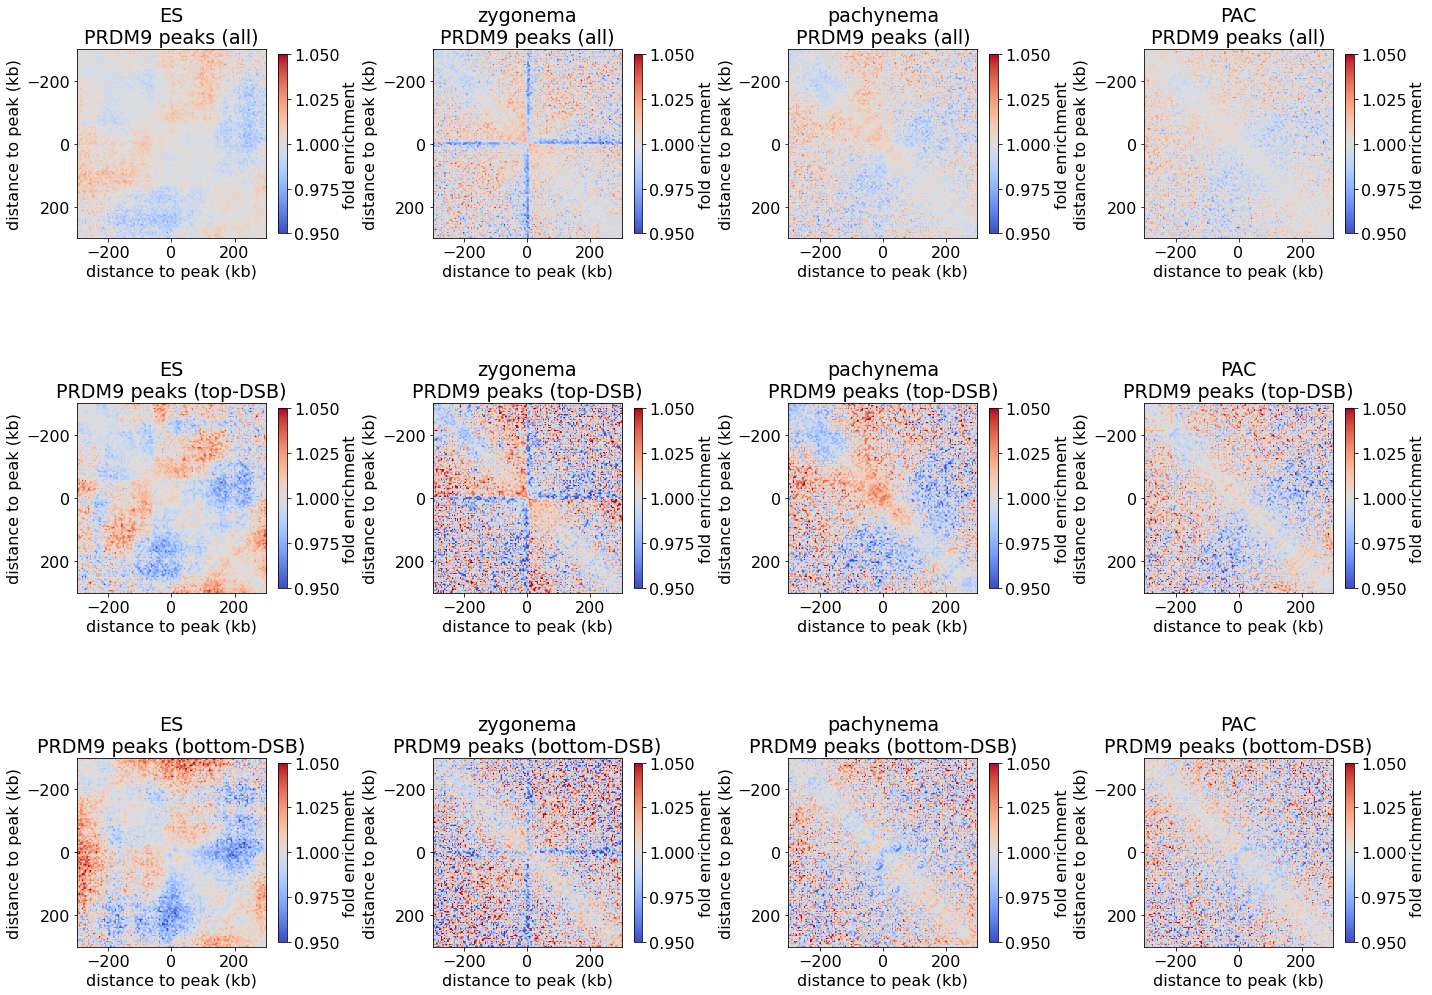

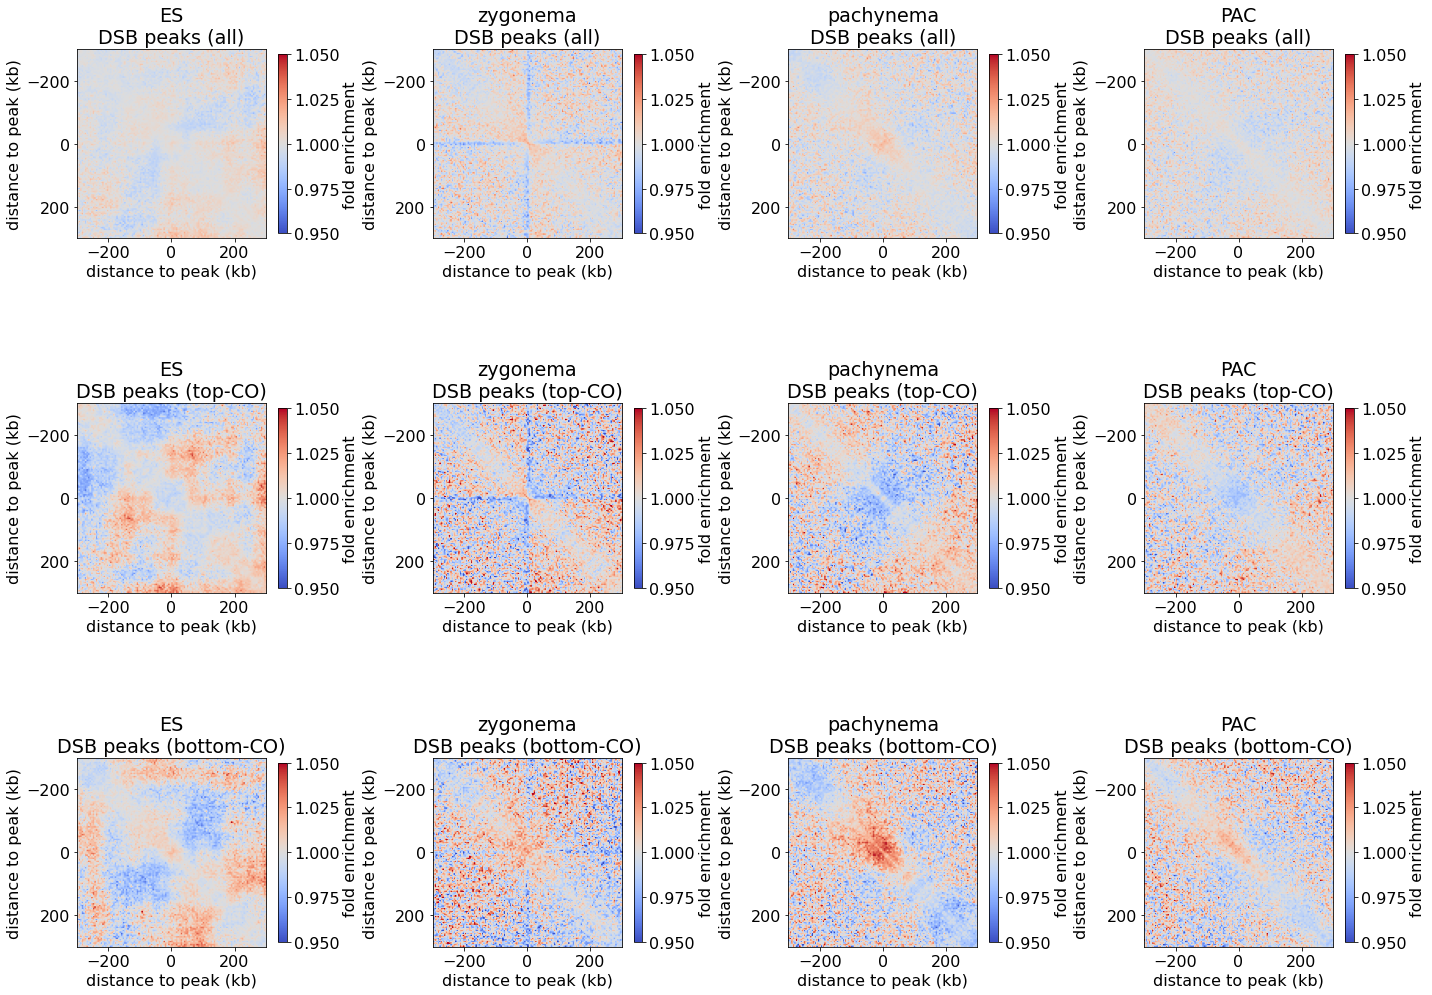

In [6]:
windowDictMetaList=[prdm9WindowDict,dsbWindowDict]
windowKeys=['prdm9','dsb']
windowDictMetaDict=dict(zip(windowKeys,windowDictMetaList))
for key in windowDictMetaDict:
    plotSnipPileups(snipWindowsDict=windowDictMetaDict[key],coolerDict=coolerListDictWPAC,saveName=f'{saveDir}/{key}_metahic.pdf')

In [ ]:
windowDictMetaList=[cohesinWindowDict,cohesinPairWindowDict,rad21lPosNegWindowDict,rad21lConvDivPairWindowDict,ctcfPosNegWindowDict,ctcfConvDivPairWindowDict]
windowKeys=['cohesin','cohesinPairs','rad21lPosNeg','rad21lConvDiv','ctcfPosNeg','ctcfConvDiv']
windowDictMetaDict=dict(zip(windowKeys,windowDictMetaList))
for key in windowDictMetaDict:
    plotSnipPileups(snipWindowsDict=windowDictMetaDict[key],coolerDict=coolerListDictWPAC,vmin=0.75,vmax=1.25,saveName=f'{saveDir}/{key}_metahic.pdf')